In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка датасета, содержащего нормальный трафиа (датасет 1)

In [2]:
with open('/home/lyumos/PycharmProjects/anomalies-detection-project/datasets processing/domain characteristics dataset/benign.csv', 'r') as file:
    df1 = pd.read_csv(file)
    df1['label'] = 0
df1.drop(df1[df1['label'] == 0].index[:32797], inplace=True)
df1.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,label
32797,2020-11-21 01:29:58.299364,14,0,0,12,0,2.781301,2,2,10,6.500000,holy,holy-light,11,0,0
32798,2020-11-21 01:29:58.624179,12,0,0,10,0,2.406304,2,3,6,3.333333,hongik,hongik,7,0,0
32799,2020-11-21 01:29:58.757205,12,0,0,10,0,2.406304,2,3,6,3.333333,hongik,hongik,7,0,0
32800,2020-11-21 01:29:59.160063,28,11,0,10,12,2.612446,6,6,7,3.833333,2,192,15,1,0
32801,2020-11-21 01:29:59.246704,12,0,0,10,0,2.406304,2,3,6,3.333333,hongik,hongik,7,0,0


Загрузка датасетов, содержащих аномалии (датасеты 2,3)

In [3]:
with open('/home/lyumos/PycharmProjects/anomalies-detection-project/datasets processing/domain characteristics dataset/abnormal_audio.csv', 'r') as file:
    df2 = pd.read_csv(file)
    df2['label'] = 1
df2.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,label
0,2020-11-22 14:52:31.248351,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,1
1,2020-11-22 14:52:31.658668,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,1
2,2020-11-22 14:52:31.898872,15,0,11,0,3,3.625000,1,1,15,15.000000,C,DESKTOP-3JF04TC,16,0,1
3,2020-11-22 14:52:32.071032,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
4,2020-11-22 14:52:32.481373,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1


In [4]:
with open('/home/lyumos/PycharmProjects/anomalies-detection-project/datasets processing/domain characteristics dataset/abnormal_exe.csv', 'r') as file:
    df3 = pd.read_csv(file)
    df3['label'] = 1
df3.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,label
0,2020-11-24 23:18:25.442015,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,2020-11-24 23:18:25.852211,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
2,2020-11-24 23:18:26.264187,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
3,2020-11-24 23:18:26.674746,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,2020-11-24 23:18:27.086793,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1


Соединение датасетов

In [5]:
df = pd.concat([df1, df2, df3])
counts = df.label.value_counts()
counts

label
1    70424
0    55777
Name: count, dtype: int64

In [6]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,label
0,2020-11-22 17:51:12.393285,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,1
1,2020-11-22 20:22:57.685069,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,1
2,2020-11-25 00:44:32.210104,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
3,2020-11-21 04:40:46.243662,13,0,0,11,0,2.789735,2,2,9,6.000000,oecd,oecd-opsi,10,0,0
4,2020-11-22 17:45:32.778533,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1


Обработка получившегося датасета

In [7]:
#нулевых значений больше нет
df.dropna(subset=['longest_word'], inplace=True)
df.isnull().sum()

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
label               0
dtype: int64

In [8]:
#тип данных 'label' - в категорию
df['label'] = df['label'].astype('category')
df.dtypes

timestamp             object
FQDN_count             int64
subdomain_length       int64
upper                  int64
lower                  int64
numeric                int64
entropy              float64
special                int64
labels                 int64
labels_max             int64
labels_average       float64
longest_word          object
sld                   object
len                    int64
subdomain              int64
label               category
dtype: object

In [9]:
#из символьного представления - к числовому для 'longest_word' и 'sld'
le = LabelEncoder()
df['longest_word_le'] = le.fit_transform(df['longest_word'])
df['sld_le'] = le.fit_transform(df['sld'])
del df['longest_word']
del df['sld']
df.rename(columns={'longest_word_le': 'longest_word'}, inplace=True)
df.rename(columns={'sld_le': 'sld'}, inplace=True)
df.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,label,longest_word,sld
0,2020-11-22 17:51:12.393285,26,9,0,10,10,2.742338,6,6,7,3.500000,13,1,1,2,38
1,2020-11-22 20:22:57.685069,25,8,0,10,9,2.556642,6,6,7,3.333333,12,1,1,2,38
2,2020-11-25 00:44:32.210104,24,7,0,10,8,2.054029,6,6,7,3.166667,11,1,1,4,62
3,2020-11-21 04:40:46.243662,13,0,0,11,0,2.789735,2,2,9,6.000000,10,0,0,3734,6669
4,2020-11-22 17:45:32.778533,24,7,0,10,8,2.054029,6,6,7,3.166667,11,1,1,4,62


In [10]:
#пропусков нет
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(df.isna().any(axis=1).sum(), "строк с как минимум одним значением NaN")
df.dropna(inplace=True)

0 строк с как минимум одним значением NaN


In [11]:
#удаление дублирующихся строк
print(df.duplicated().sum(), "полностью повторяющихся строк к удалению")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

122 полностью повторяющихся строк к удалению


In [12]:
#удаление столбца 'timestamp', не несущего в данном случае информации
del df['timestamp']
df.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,label,longest_word,sld
0,26,9,0,10,10,2.742338,6,6,7,3.500000,13,1,1,2,38
1,25,8,0,10,9,2.556642,6,6,7,3.333333,12,1,1,2,38
2,24,7,0,10,8,2.054029,6,6,7,3.166667,11,1,1,4,62
3,13,0,0,11,0,2.789735,2,2,9,6.000000,10,0,0,3734,6669
4,24,7,0,10,8,2.054029,6,6,7,3.166667,11,1,1,4,62


In [13]:
#для составления итогового датасета
df.to_csv('raw_dc_dataset.csv', index=False)

In [14]:
#Уберем из датафрейма метку (для дальнейшего разделения данных на обучающую и тестовую выборки) - получим X:
X = df.loc[:, df.columns != 'label']
y = df['label']

In [15]:
#нормализуем данные
scaler = MinMaxScaler()
new_df = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

new_df.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,longest_word,sld
0,0.705882,0.310345,0.0,0.294118,0.714286,0.599242,0.857143,0.833333,0.166667,0.065574,0.333333,1.0,0.000338,0.003629
1,0.676471,0.275862,0.0,0.294118,0.642857,0.553469,0.857143,0.833333,0.166667,0.060109,0.303030,1.0,0.000338,0.003629
2,0.647059,0.241379,0.0,0.294118,0.571429,0.429578,0.857143,0.833333,0.166667,0.054645,0.272727,1.0,0.000676,0.005921
3,0.323529,0.000000,0.0,0.323529,0.000000,0.610926,0.285714,0.166667,0.233333,0.147541,0.242424,0.0,0.631490,0.636902
4,0.647059,0.241379,0.0,0.294118,0.571429,0.429578,0.857143,0.833333,0.166667,0.054645,0.272727,1.0,0.000676,0.005921


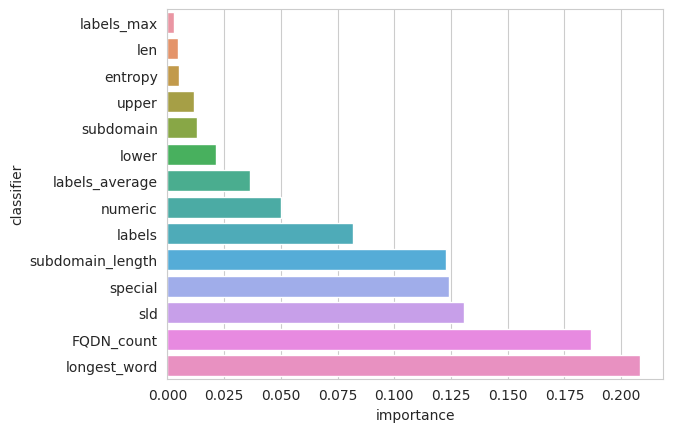

In [16]:
#определение значимости признаков с помощью RF и коэффициента Gini
clf = RandomForestClassifier()
clf.fit(new_df, y)
importances = clf.feature_importances_
classifiers = ['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len', 'subdomain', 'longest_word', 'sld']
df_sns = pd.DataFrame({'importance': importances, 'classifier': classifiers})
df_sns = df_sns.sort_values('importance', ascending=True)
sns.barplot(x='importance', y='classifier', data=df_sns)
plt.show()

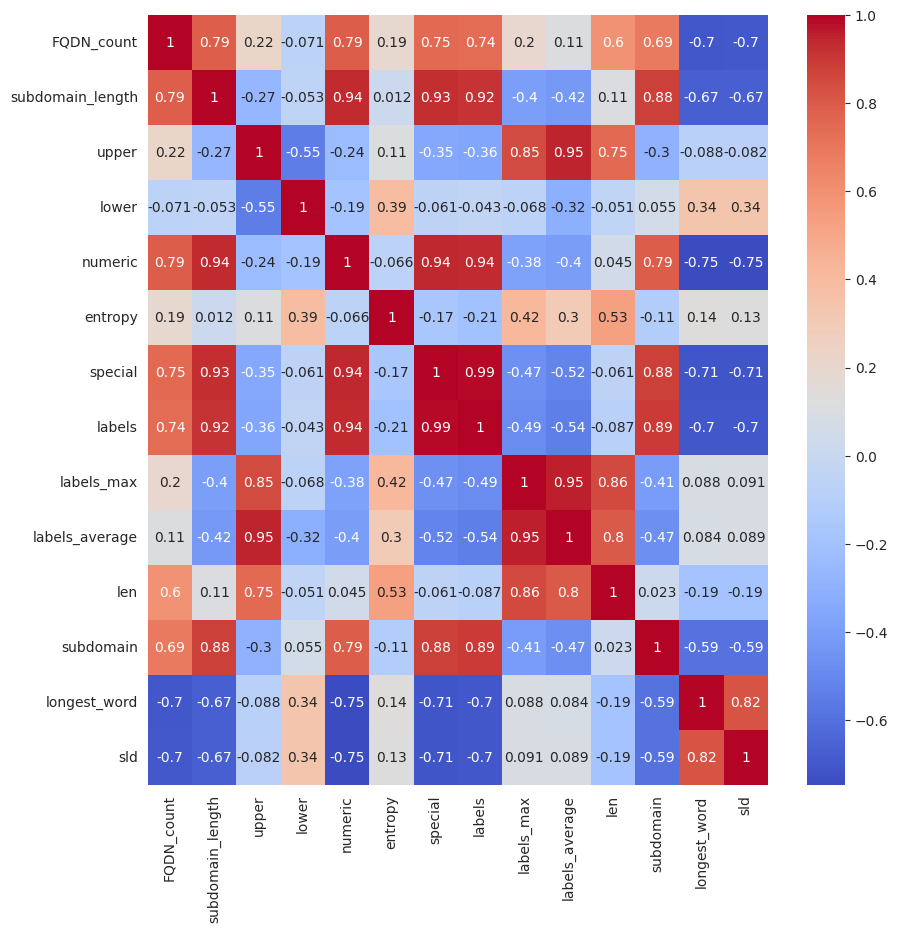

In [17]:
#построение корреляционной матрицы
corr_matrix = new_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

В результате выбора наиболее значимых признаков по представленным двум диаграммам, были выбраны следующие:
'FQDN_count', 'subdomain_length', 'longest_word', 'sld', 'len', 'lower', entropy'

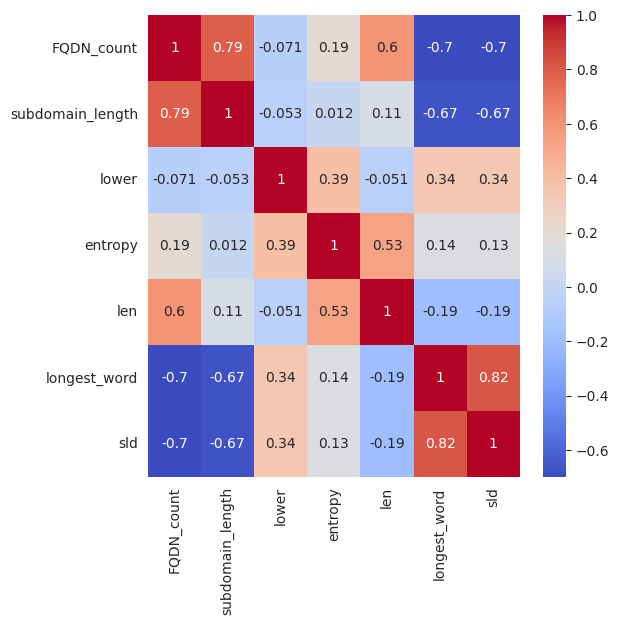

In [18]:
#гиперкорреляции между выбранными признаками не наблюдается
X1 = df.loc[:, ~df.columns.isin(['upper', 'numeric', 'labels_max', 'labels_average', 'subdomain', 'label', 'special', 'labels'])]
check_df = pd.DataFrame(
    scaler.fit_transform(X1),
    columns=X1.columns
)
corr_matrix = check_df.corr()
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

In [19]:
final_df = pd.concat([check_df, df['label']], axis=1)
final_df.to_csv('dc_dataset.csv', index=False)